# FPF Gain approximation code

In [1]:
import numpy as np
from sympy import *
# import sympy as sp
from scipy.spatial.distance import pdist,squareform
from scipy.stats import norm
import scipy.integrate as integrate
import math

from timeit import default_timer as timer

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text',usetex = True)
import seaborn as sns

from sklearn.linear_model import ridge

from IPython.display import clear_output

%matplotlib notebook
#%matplotlib inline

## Defining some functions

### get_samples() - Function to generate samples from a multi-dimensional 1d- Gaussian mixture $\times$  (d-1) independent Gaussian distribution 

In [2]:
def get_samples(N, mu, sigma_b, w, dim, gm = 1, sigma = None, seed = None):
    np.random.seed(seed)
    Xi  = np.zeros((N,dim))
    for i in range(N):
        for d in range(gm):
            if np.random.uniform() <= w[0]:
                Xi[i,d] = mu[0]  + sigma_b[0] * np.random.normal()
            else:
                Xi[i,d]  = mu[1]  + sigma_b[1] * np.random.normal()
        for d in range(gm, dim):
            Xi[i,d] = sigma * np.random.normal()
    return Xi

### mean_squared_error() - Function to compute the mean square error in gain function approximation

In [3]:
def mean_squared_error(K_exact, K_approx):
    N = len(K_exact)
    mse = (1/N) * np.linalg.norm(K_exact - K_approx)**2
    # mse2 = np.sum(((K_exact - K_approx)**2) *np.concatenate(p_vec(Xi)))
    return mse

## Different gain approximation algorithms

### gain_rkhs_2N() - Function to approximate FPF gain using optimal RKHS method  
uses the extended representer theorem in - https://www.sciencedirect.com/science/article/pii/S0377042707004657?via%3Dihub

Algorithm for a scalar example
\begin{equation}
\text{K}(x) = \sum_{i=1}^N \Bigl[ \beta^0_i K(x^i,x) + \beta^1_i \frac{\partial K} {\partial x}(x^i,x) \Bigr]
\end{equation}

\begin{equation}
	\beta ^* = M^{-1} b
\end{equation}

\begin{equation}
	\begin{aligned}
	\text{where,
	}
	\quad
	M & := \frac{1}{N} \left[\begin{array}{c} M_y\\ \hline M_{xy} \end{array}\right] [ M_x \,| M_{xy}] + \lambda  \left[
	\begin{array}{c|c}
	M_0 & M_y \\
	\hline
	M_x & M_{xy}
	\end{array}
	\right] \\
	b & :=  \frac{1}{N} \left[ \begin{array}{c} M_0 \\ \hline M_x \end{array}\right] \tilde{c}	\end{aligned}
\end{equation}

\begin{aligned}
M_0(i,j) &:= K(x^i,x^j)
\quad
& M_x(i,j) &:= \frac{\partial K}{\partial x}(x^i,x^j)
\\
M_y(i,j) &:= \frac{\partial K}{\partial y}(x^i,x^j)
\quad
& M_{xy}(i,j) &:= \frac{\partial^2 K}{\partial x \partial y}(x^i,x^j).
\end{aligned}

In [4]:
def gain_rkhs_2N(Xi, C, epsilon, Lambda, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    K = np.zeros((N,dim))
    Ker_x = np.array(np.zeros((N,N,dim)))
    Ker_xy = np.array(np.zeros((N,N,dim)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            Ker_x[i,j,:] = -(Xi[i,:]-Xi[j,:]) * Ker[i,j] / (2 * epsilon)
            Ker_xy[i,j,:] = -(((Xi[i,:] - Xi[j,:])**2) / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon) # Negative of the second Gaussian derivative, as this is K_xy and not K_x2
    
    eta = np.mean(C)
    Y = (C -eta)
    
    # Constructing block matrices for future use
    # K_big      = [ Ker Ker_x ; Ker_x' Ker_x_y];
    # K_thin_yxy = [ Ker_x ; Ker_x_y]; 
    # K_thin_x   = [ Ker ; Ker_x'];
    K_big      = np.concatenate((np.concatenate((Ker,np.transpose(np.reshape(Ker_x,(N,N)))),axis = 1), np.concatenate((np.reshape(Ker_x,(N,N)), np.reshape(Ker_xy,(N,N))),axis =1)))
    K_thin_yxy = np.concatenate((np.transpose(np.reshape(Ker_x,(N,N))), np.reshape(Ker_xy,(N,N))))
    # K_thin_xxy = np.concatenate((Ker_x,Ker_xy), axis = 1)
    K_thin_x   = np.concatenate((Ker, np.reshape(Ker_x,(N,N))))
    
    # b used in the extended representer theorem algorithm - searching over all of the Hilbert space H
    b_2N        = (1/N) * np.dot(K_thin_x, Y)
    M_2N        = Lambda * K_big + (1/N) * np.matmul(K_thin_yxy, np.transpose(K_thin_yxy))
    beta_2N     = np.linalg.solve(M_2N, b_2N)   
    
    for i in range(N):
        for j in range(N):
            K[i,:] = K[i,:] + beta_2N[j] * Ker_x[i,j,:] + beta_2N[N+j] * Ker_xy[i,j,:]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,0],'r*')
        plt.plot(Xi, Ker_x[:,0], 'b*')
        plt.plot(Xi, Ker_xy[:,0],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

### gain_rkhs_dN() - Extension to d-dimensions

In [5]:
def gain_rkhs_dN(Xi, C, epsilon, Lambda, diag = 1):
    start = timer()
    
    N,dim = Xi.shape
    K = np.zeros((N,dim))
    Ker_x  = np.array(np.zeros((N,N,dim)))
    Ker_xy = np.array(np.zeros((N,N, dim+1, dim+1)))
    # Ker_xy = np.array(np.zeros((N,N, dim, dim)))
    
    K_big  = np.array(np.zeros(((dim+1)*N, (dim+1)*N)))
    K_thin_x =np.array(np.zeros(((dim+1)*N, N)))
    K_thin_xy = np.array(np.zeros(((dim+1)*N, dim * N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            Ker_x[i,j,:] = -(Xi[i,:]-Xi[j,:]) * Ker[i,j] / (2 * epsilon)
            # Ker_x2[i,j,:] = -(((Xi[i,:] - Xi[j,:])**2)  / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon) # Negative of the second Gaussian derivative, as this is K_xy and not K_x2
    
    for d_i in range(dim + 1):
        for d_j in range(dim + 1):
            if d_i == 0:
                if d_j == 0:
                    K_big[d_i * N : (d_i + 1) *N, d_j * N : (d_j +1) * N ] = Ker
                else:
                    K_big[d_i * N : (d_i + 1) *N, d_j * N : (d_j +1) * N ] = np.transpose(Ker_x[:,:,d_j-1])
            elif d_j == 0:
                K_big[d_i * N : (d_i + 1) *N, d_j * N : (d_j +1) * N ] = Ker_x[:,:,d_i-1]
            elif d_i == d_j:
                for i in range(N):
                    for j in range(N):
                        Ker_xy[i,j, d_i, d_j] = -(((Xi[i,d_i-1] - Xi[j,d_i-1])**2)  / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon) 
                K_big[d_i * N : (d_i + 1) *N, d_j * N : (d_j +1) * N ] = Ker_xy[:,:,d_i, d_j]
            else:
                for i in range(N):
                    for j in range(N):
                        Ker_xy[i,j, d_i, d_j] = -((Xi[i,d_i-1] - Xi[j,d_i-1])* (Xi[i,d_j-1] - Xi[j,d_j-1])) / (2 * epsilon) * Ker[i,j] / (2 * epsilon) # Negative of the second Gaussian derivative, as this is K_xy and not K_x2        
                K_big[d_i * N : (d_i + 1) *N, d_j * N : (d_j +1) * N ] = Ker_xy[:,:,d_i, d_j]
            
    for d_i in range(dim + 1):
        if d_i == 0:
            K_thin_x[d_i *N :(d_i+1)*N,: ] = Ker
        else:
            K_thin_x[d_i *N :(d_i+1)*N,: ] = Ker_x[:,:,d_i-1]
            
    for d_i in range(dim+1):
        for d_j in range(dim):
            if d_i == 0:
                K_thin_xy[d_i * N :(d_i+1)*N, d_j * N : (d_j+1) *N] = np.transpose(Ker_x[:,:,d_j])
            else:
                K_thin_xy[d_i * N :(d_i+1)*N, d_j * N :(d_j+1) *N] = Ker_xy[:,:,d_i,d_j+1]
    
    eta = np.mean(C)
    Y = (C -eta)
    
    # b used in the extended representer theorem algorithm - searching over all of the Hilbert space H
    b_dN        = (1/N) * np.dot(K_thin_x, Y)
    M_dN        = Lambda * K_big + (1/N) * np.matmul(K_thin_xy, np.transpose(K_thin_xy))
    beta_dN     = np.linalg.solve(M_dN, b_dN)   
    
    for i in range(N):
        for j in range(N):
            K[i,:] = K[i,:] + beta_dN[j] * Ker_x[i,j,:] 
            for d_i in range(dim):
                K[i,:] = K[i,:] + beta_dN[(d_i + 1) *N + j] * Ker_xy[i,j,(d_i+1),1:]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi[:,0], Ker[:,1],'r*')
        plt.plot(Xi, Ker_x[:,1,0], 'b*')
#         plt.plot(Xi, Ker_xy[:,1,1,1],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

### gain_rkhs_N() - Function to approximate FPF gain using subspace RKHS method  
uses normal representer theorem, obtains optimal solution on a subspace of RKHS.

Algorithm
\begin{equation}
\text{K}(x) = \sum_{i=1}^N \beta^*_i \frac{\partial K}{\partial x} (x^i,x)  
\end{equation}
\begin{equation}
\beta  := M^{-1} b   \,,
\end{equation}
where $ M := N^{-1} M_y M_x + \lambda M_0$ and $ b := N^{-1} M_0 \, \tilde{c}  $.

In [6]:
def gain_rkhs_N(Xi, C, epsilon, Lambda, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    K = np.zeros((N,dim))
    Ker_x = np.array(np.zeros((N,N,dim)))
    Ker_x_sum = np.zeros((N,N))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))    
    for i in range(N):
        for j in range(N):
            Ker_x[i,j,:] = -(Xi[i,:]-Xi[j,:]) * Ker[i,j] / (2 * epsilon)
    
    eta = np.mean(C)
    Y = (C -eta)
    
    b_N = (1/ N) * np.dot(Ker,Y)
    for d in np.arange(dim):
        Ker_x_sum+= np.matmul(Ker_x[:,:,d], Ker_x[:,:,d].transpose())
    M_N = Lambda * Ker + (1/ N) * Ker_x_sum
    beta_N = np.linalg.solve(M_N,b_N)
    
    for i in range(N):
        for j in range(N):
            K[i,:] = K[i,:] + beta_N[j] * Ker_x[i,j,:]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,100],'r*')
        plt.plot(Xi, Ker_x[:,100,:], 'b*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

### gain_exact() - Function to compute the exact FPF gain by numerical integration

Algorithm
\begin{equation} 
\text{K}(x) =  - \frac{1}{p(x)} \int_{-\infty}^{x} (c(y) - \hat{c}) p(y) dy
\end{equation}

In [7]:
def gain_exact(Xi, c, p):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    integral = np.zeros(N)
    
    step = 0.01
    xmax = max(mu) + 10
    
    p_vec = lambdify(x, p, 'numpy')
    c_vec = lambdify(x, c, 'numpy')
    cp    = lambdify(x, c*p, 'numpy')
    c_hat = integrate.quad(cp, -np.inf, np.inf)[0]
    
    for i in range(N):
        integral[i] = 0
        for xj in np.arange(Xi[i], xmax + 10,  step):
            integral[i] = integral[i] + p_vec(xj) * ( c_vec(xj) - c_hat) * step
        K[i] = integral[i]/ p_vec(Xi[i])
            
    end = timer()
    print('Time taken' , end - start)
    return K

Using scipy.integrate.quad

In [8]:
def gain_num_integrate(Xi, c, p, x, d=0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    integral = np.zeros(N)
     
#    if Xi.shape[1] == 1:
#         p_x = lambdify(x[0], p, 'numpy')
#         cp_x  = lambdify(x[0], c*p, 'numpy')
#         c_hat = integrate.quad(cp_x, -np.inf, np.inf)[0]
#         integrand_x = lambdify(x[0], p * (c - c_hat) , 'numpy')
#         integrand = lambda x: integrand_x(x)

#         p_x = lambdify(x, p, 'numpy')
#         cp_x  = lambdify(x, c*p, 'numpy')
#         c_hat = integrate.quad(cp_x, -np.inf, np.inf)[0]
#         integrand_x = lambdify(x, p * (c - c_hat) , 'numpy')
#         integrand = lambda x: integrand_x(x)
#    else:
    p_x = lambdify(x[0], p, 'numpy')
    cp_x  = lambdify(x[0], c*p, 'numpy')
    c_hat = integrate.quad(cp_x, -np.inf, np.inf)[0]
    integrand_x = lambdify(x[0], p * (c - c_hat) , 'numpy')
    integrand = lambda x: integrand_x(x)
   
    for i in range(N):
        if Xi.shape[1] == 1:
            integral[i] = integrate.quad( integrand, -np.inf, Xi[i])[0]
            K[i] = - integral[i]/ p_x(Xi[i])
        else:
            integral[i] = integrate.quad( integrand, -np.inf, Xi[i,d])[0]
            K[i] = - integral[i]/ p_x(Xi[i,d])
    # K = np.reshape(K,(N,1))
    
    end = timer()
    print('Time taken' , end - start)
    return K

### gain_coif() - Function to approximate FPF gain using Markov kernel approx. method -
Based on the Markov semigroup approximation method in https://arxiv.org/pdf/1902.07263.pdf

Algorithm  
\begin{enumerate}
\item Calculate $g_{ij} = \exp(-|X^i - X^j|^2/ 4\epsilon)$ for $i,j = 1$ to $N$  
\item Calculate $k_{ij} = \frac{g_{ij}}{\sqrt{\sum_l g_{il}}\sqrt{\sum_l g_{jl}}}$  
\item Calculate $d_i = \sum_j k_{ij}$  
\item Calculate $\text{T}_{ij} = \frac{k_{ij}}{d_i}$  
\item Calculate $\pi_i = \frac{d_i}{\sum_j d_j}$  
\item Calculate $ \hat{h} = \sum_{i = 1}^N \pi_i h(X^i)$  
\item Until convergence, $\Phi_i = \sum_{j=1}^N \text{T}_{ij} \Phi_j + \epsilon (h - \hat{h})$  
\item Calculate $r_i = \Phi_i + \epsilon h_i$  
\item Calculate $s_{ij} = \frac{1}{2\epsilon} \text{T}_{ij} (r_j - \sum_{k=1}^N \text{T}_{ik} r_k)$  
\item Calulate $\text{K}_i  = \sum_j s_{ij} X^j$
\end{enumerate}

In [9]:
def gain_coif(Xi, C, epsilon, Phi, No_iterations = 50000, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    k = np.zeros((N,N))
    K = np.zeros((N,dim))
    d = np.zeros(N)
    T = np.zeros((N,N))
    Phi = np.zeros(N)
    sum_term = np.zeros((N,dim))
    max_diff = 1
    
    iterations = 1
    
    g = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))    
    for i in range(N):
        for j in range(N):
            k[i,j] = g[i,j] / (np.sqrt( (1/N) * sum(g[i,:])) * np.sqrt( (1/N)* sum(g[j,:])))
        d[i] = np.sum(k[i,:])
        T[i,:] = np.divide(k[i,:], np.sum(k[i,:]))
    pi = np.divide(d, np.sum(d))
    C_hat = np.dot(pi, C)
                      
    while((max_diff > 0) & ( iterations < No_iterations )):
        Phi_new = np.matmul(T,Phi) + (epsilon * np.concatenate(C - C_hat)).transpose() 
        max_diff = max(Phi_new - Phi) - min(Phi_new - Phi)
        Phi  = Phi_new
        iterations += 1
    
    r = Phi + epsilon * np.concatenate(C)
    for i in range(N):
        sum_term[i] = np.dot( T[i,:], r)
        K[i,:] = np.zeros(dim)
        for j in range(N):
            K[i,:] = K[i,:] + (1/ (2 * epsilon)) * T[i,j] * (r[j] - sum_term[i]) * Xi[j,:]                                  
    if diag == 1:
        plt.figure()
        plt.plot(Xi, g[1,:], 'r*')
        plt.show()
    
    end = timer()
    print('Time taken' , end - start)
    
    return K

Slightly older version of Markov kernel approximation - from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7799105

In [10]:
def gain_coif_old(Xi, C, epsilon, Phi, No_iterations =50000, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    k = np.zeros((N,N))
    K = np.zeros((N,dim))
    d = np.zeros(N)
    T = np.zeros((N,N))
    Phi = np.zeros(N)
    sum_term = np.zeros((N,dim))
    max_diff = 1
        
    iterations = 1
    
    g = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            k[i,j] = g[i,j] / (np.sqrt( (1/N) * sum(g[i,:])) * np.sqrt( (1/N)* sum(g[j,:])))
        d[i] = np.sum(k[i,:])
        T[i,:] = np.divide(k[i,:], np.sum(k[i,:]))
                      
    while((max_diff > 0) & ( iterations < No_iterations )):
        Phi_new = np.matmul(T,Phi) + (epsilon * np.concatenate(C)).transpose() 
        max_diff = max(Phi_new - Phi) - min(Phi_new - Phi)
        Phi  = Phi_new
        iterations += 1
    
    for i in range(N):
        sum_term[i,:] = np.dot( T[i,:], Xi)
        K[i,:] = np.zeros(dim)
        for j in range(N):
            K[i,:] = K[i,:] + (1/ (2 * epsilon)) * T[i,j] * Phi[j,] * (Xi[j,:] - sum_term[i,:])   
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, g[1,:], 'r*')
        plt.show()
    
    end = timer()
    print('Time taken' , end - start)
    
    return K

### gain_rkhs_om() - Function to approximate FPF gain using RKHS OM method - Adds a Lagrangian parameter $\mu$ to make use of the constant gain approximation
Algorithm

$\beta^*$ obtained by solving the set of linear equations
\begin{equation}
\begin{aligned}
0  &=  2 \Bigl(  \frac{1}{N}  \sum_{k=1}^d M_{x_k}^T M_{x_k}   +  \lambda M_0 \Bigr) \beta ^* + \frac{ \kappa \mu ^*}{N}+  \frac{2}{N} \Bigl( \kappa \text{K}^*  -   M_0 \tilde{c} \Bigr)  \\
0  & = \kappa^{T} \beta^*
\end{aligned}
\end{equation}

In [11]:
def gain_rkhs_om(Xi, C, epsilon, Lambda, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    K = np.zeros((N,dim))
    Ker_x = np.array(np.zeros((N,N,dim)))
    # Ker_xy = np.array(np.zeros((N,N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    
    for i in range(N):
        for j in range(N):
            Ker_x[i,j,:] = -(Xi[i,:]-Xi[j,:]) * Ker[i,j] / (2 * epsilon)
            # Ker_xy[i,j] = (((Xi[i] - Xi[j])**2) / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon)
    # Ker_x_ones = np.dot(np.ones((1,N)), Ker_x)
    Ker_x_ones = np.dot(np.transpose(Ker_x), np.ones((N,1)))

    eta = np.mean(C)
    Y = (C -eta)
    
    K_hat = np.mean(Y * Xi, axis = 0)

    b_m = (2/ N) * np.dot(Ker,Y) - (2/ N) * np.dot( np.moveaxis(Ker_x_ones,0,2), K_hat) 
    b_m = np.append(b_m, np.zeros((dim,1)))
    
    Ker_x_sum = np.zeros((N,N))
    for d_i in range(dim):
        Ker_x_sum = Ker_x_sum + np.matmul(Ker_x[:,:,d_i], Ker_x[:,:,d_i].transpose())
    M_m = 2 * Lambda * Ker + (2 / N) * Ker_x_sum
    M_m = np.vstack((M_m, (1/N) * np.squeeze(Ker_x_ones)))
    M_m = np.hstack((M_m, np.append(np.squeeze(np.transpose(Ker_x_ones),axis =0),np.zeros((dim,dim)),axis =0))) #.reshape(len(M_m),1))
    
    beta_m = np.linalg.solve(M_m,b_m)
    
    # K.fill(K_hat)
    K  = np.tile(K_hat, (N,1))
    for i in range(N):
        for j in range(N):
            K[i,:] = K[i,:] + beta_m[j] * Ker_x[i,j,:]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,0],'r*')
        plt.plot(Xi, Ker_x[:,0], 'b*')
        plt.plot(Xi, Ker_xy[:,0],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

## Hyperparameter selection using grid search 
### select_hyperparameters() -  Hyper parameter selection for RKHS OM for dim $d$

In [12]:
def select_hyperparameters(method,Lambda = None,eps = None):
    
    # Choose hyperparameters for which algorithm
    if method is None:
        method = input('Input the algorithm (coif, rkhs_N, rkhs_dN, om,) ')
    
    # Run parameters
    No_runs = int(input('Input the number of independent runs - '))
    if No_runs is None:
        No_runs = 100

    # FPF parameters - No. of particles
    N = int(input('Input the number of particles - '))
    if N is None:
        N = 500
    
    # System parameters
    dim = int(input('Input the dimension of the system - '))     # dimension of the system
    x = symbols('x0:%d'%dim)
    c_coef = np.ones((1,dim)) 
    c =  c_coef.dot(x)      # Observation function (Eg: for d = 2, c(x) = x1 + x2)
    c_x = lambdify(x, c, 'numpy')

        
    # Parameters of the prior density \rho_B - 2 component Gaussian mixture density
    gm = dim     # No. of dimensions with Gaussian mixture densities in the dim-dimensional density, should be <= dim
    m = 2        # No of components in the Gaussian mixture
    sigma_b = [0.4472, 0.4472]   # Gives \sigma^2 = 0.2
    mu_b  = [-1, 1]
    w_b   = [0.5, 0.5]
    w_b[-1] = 1 - sum(w_b[:-1])
    p_b = 0
    for m in range(len(w_b)):
        p_b = p_b + w_b[m] * (1/ np.sqrt(2 * math.pi * sigma_b[m]**2))* exp(-(x[0] - mu_b[m])**2/ (2* sigma_b[m]**2))
    p_b_x = lambdify(x[0], p_b, 'numpy')
    # Standard deviation for the Gaussian component (if any)
    sigma = 0.4472  # Chosen so that \sigma^2 = 0.2 as in the reference
    
    # Hyperparameter grid
    if eps is None:
        eps = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
    if Lambda is None:
        Lambda =[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    if method == 'coif':
        mse  = np.zeros((No_runs, len(eps)))
    else:
        mse  = np.zeros((No_runs, len(eps), len(Lambda)))
    mse_const= np.zeros(No_runs)  # Used as baseline to compare the performance of the method
    for run in range(No_runs):
        clear_output()
        print('Run ',run)
        # Xi  = get_samples(N, mu_b, sigma_b, w_b, dim, gm, sigma, seed = run)
        Xi  = get_samples(N, mu_b, sigma_b, w_b, dim, gm, sigma)
        if dim == 1:
            Xi = np.sort(Xi,kind = 'mergesort')
        C = np.reshape(c_x(*Xi.T),(len(Xi),1))
    
        K_exact = np.zeros((N, dim))
        for d in range(gm):
            K_exact[:,d]  = gain_num_integrate(Xi, x[0], p_b, x, d)
        
        for i,eps_i in enumerate(eps):
            if method == 'coif':
                Phi = np.zeros(N)
                K_approx = gain_coif(Xi, C, eps_i, Phi, diag = 0) 
                mse[run, i] = mean_squared_error(K_exact, K_approx)
            elif method == 'rkhs_N':
                for j,Lambda_j in enumerate(Lambda):  
                    K_approx = gain_rkhs_N(Xi, C, eps_i, Lambda_j, diag = 0)
                    mse[run, i,j] = mean_squared_error(K_exact, K_approx)
            elif method == 'rkhs_dN':
                for j,Lambda_j in enumerate(Lambda):  
                    K_approx = gain_rkhs_dN(Xi, C, eps_i, Lambda_j, diag = 0)
                    mse[run, i,j] = mean_squared_error(K_exact, K_approx)
            elif method == 'om':
                for j,Lambda_j in enumerate(Lambda):  
                    K_approx = gain_rkhs_om(Xi, C, eps_i, Lambda_j, diag = 0)
                    mse[run, i,j] = mean_squared_error(K_exact, K_approx)
            else:
                for j,Lambda_j in enumerate(Lambda):  
                    print('Invalid method provided')
        
        # Baseline error calculation        
        eta = np.mean(C)
        Y = (C -eta)
        K_const = np.mean(Y * Xi, axis = 0)
        mse_const[run] = mean_squared_error(K_exact, K_const)     
    
    if method == 'coif':
        i_min = np.argmin(np.mean(mse,axis=0))
        print('Best value of $\epsilon', eps[i_min])
        K_approx_best = gain_coif(Xi, C, eps[i_min], Phi, diag = 0)
    else:
        i_min, j_min = np.unravel_index(np.argmin(np.mean(mse,axis =0)),np.mean(mse, axis =0).shape)
        print('Best value of  $\lambda$', Lambda[j_min])
        print('Best value of $\epsilon$', eps[i_min])
        if method == 'rkhs_N':
            K_approx_best = gain_rkhs_N(Xi, C, eps[i_min], Lambda[j_min], diag = 0)
        elif method == 'rkhs_dN':
            K_approx_best = gain_rkhs_dN(Xi, C, eps[i_min], Lambda[j_min], diag = 0)
        elif method == 'om':
            K_approx_best = gain_rkhs_om(Xi, C, eps[i_min], Lambda[j_min], diag = 0)   
    
    print('\n')
    print('MSE for const. gain approx.', np.mean(mse_const))
    plt.figure()
    sns.distplot(mse_const, label = 'Const. gain')
    plt.show()
    
    ### Displaying the plots
    marker_size  = 3
    plt.rc('text', usetex=True)
    for d in np.arange(dim):
        fig,ax1 = plt.subplots()
        ax1.plot(Xi[:,d], K_exact[:,d], 'bv', markersize = marker_size, label ='Exact gain')
        ax1.plot(Xi[:,d], K_approx_best[:,d], 'm*', markersize = marker_size, label = '$'+method+'$')
        ax1.axhline(y= K_const[d], color = 'y', linestyle = '-', label ='Const. gain') 
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend()
        ax2 =ax1.twinx()
        ax2.plot(np.arange(-2,2,0.01), p_b_x(np.arange(-2,2,0.01)),'k.-', markersize =1, label = r'$\rho(x)$')
        ax2.set_ylabel(r'$\rho(x)$')
        ax2.legend(loc=1)
        ax1.set_xlabel('Particle Locations')
        ax1.set_ylabel('Gain $K(x)$')
        ax1.legend()
        #plt.xticks(rotation = 45)
        #plt.tight_layout()
        plt.show()     
    if method == 'coif':
        return mse, eps, eps[i_min]
    else:
        return mse,Lambda, eps, Lambda[j_min], eps[i_min]

### contour_lambda_eps() - Function to plot contour plots of mses vs a grid of $\lambda$ and $\epsilon$ values

In [13]:
def contour_lambda_eps(mse_mean, Lambda, eps, contour_levels = None):
    fig = plt.figure(figsize =(10,8))
    if contour_levels:
        cont = plt.contourf(eps, np.log10(Lambda),mse_mean.transpose(), contour_levels)
    else:
        cont = plt.contourf(eps, np.log10(Lambda),mse_mean.transpose())

    # cont = plt.contourf(eps, np.log10(Lambda),mse_mean.transpose())
    fig.colorbar(cont)
    plt.xlabel('$\epsilon$', size = 24)
    plt.xticks(fontsize = 24)
    plt.yticks(fontsize = 24)
    plt.ylabel('$\log_{10}(\lambda)$', size = 24)
    plt.show()
    return fig

### plot_hist_mse() - Function to plot a histogram of mses obtained from independent trials

In [14]:
def plot_hist_mse(mse,Lambda,eps):
    plt.figure(figsize = (10,8))    
    for i,eps_i in enumerate(eps):
            for j,Lambda_j in enumerate(Lambda):
                sns.distplot(mse[:,i,j], label = str(Lambda_j) +',' +str(eps_i))
                plt.legend()
    plt.title('Histograms of mse obtained using various algorithms for '+ str(No_runs) + ' trials')
    plt.show()

## Experiments
### Hyperparameter selection for $d=1$
#### RKHS N

Run  99
Time taken 0.511451066005975
Time taken 2.5814225130015984
Time taken 2.040648167952895
Time taken 2.090039349044673
Time taken 2.050637994077988
Time taken 2.022154554957524
Time taken 2.0017077589873224
Time taken 2.020439137937501
Time taken 1.987744101905264
Time taken 2.0142302319873124
Time taken 1.9686939999228343
Time taken 2.021000002976507
Time taken 2.19188458903227
Time taken 2.18675183004234
Time taken 2.096773382043466
Time taken 2.0247608659556136
Time taken 2.024858962977305
Time taken 2.061760855023749
Time taken 1.999833708978258
Time taken 2.037393835023977
Time taken 2.037920420989394
Time taken 2.0415328630479053
Time taken 1.9677797670010477
Time taken 1.9904331939760596
Time taken 1.969254866009578
Time taken 1.9546063540037721
Time taken 2.0019907439127564
Time taken 1.9278937639901415
Time taken 1.949627851950936
Time taken 2.0350657689850777
Time taken 2.0129465869395062
Time taken 2.139859018032439
Time taken 2.0239421779988334
Time taken 2.0434014420

<IPython.core.display.Javascript object>


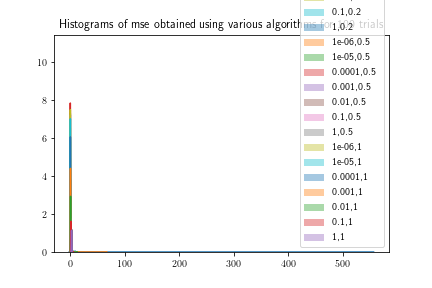

MSE for rkhs_N 14.56022037724968
MSE for rkhs_N 2.1262127850154737
MSE for rkhs_N 0.9219671348679458
MSE for rkhs_N 0.6273873953150434
MSE for rkhs_N 0.5147980635379213
MSE for rkhs_N 1.7896200270427145
MSE for rkhs_N 2.7078831717193363
MSE for rkhs_N 0.22455044044329278
MSE for rkhs_N 0.19373028815454119
MSE for rkhs_N 0.16961794686768342
MSE for rkhs_N 0.14438945070216916
MSE for rkhs_N 0.17001898663396742
MSE for rkhs_N 0.9960641626442621
MSE for rkhs_N 2.429988402806517
MSE for rkhs_N 0.14651632883218493
MSE for rkhs_N 0.13553486071403584
MSE for rkhs_N 0.12918344226910666
MSE for rkhs_N 0.12810019129695838
MSE for rkhs_N 0.18459579068607218
MSE for rkhs_N 0.8906794286601837
MSE for rkhs_N 2.344282954694528
MSE for rkhs_N 0.14926357312055055
MSE for rkhs_N 0.16674259377601267
MSE for rkhs_N 0.19642072572425306
MSE for rkhs_N 0.24330031196554444
MSE for rkhs_N 0.3568171881941539
MSE for rkhs_N 0.971308479177929
MSE for rkhs_N 2.2984579810851082
MSE for rkhs_N 0.24273044553841266
MSE

<IPython.core.display.Javascript object>


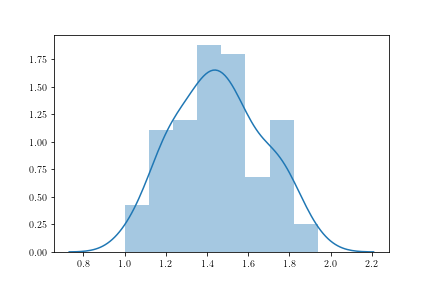

<IPython.core.display.Javascript object>


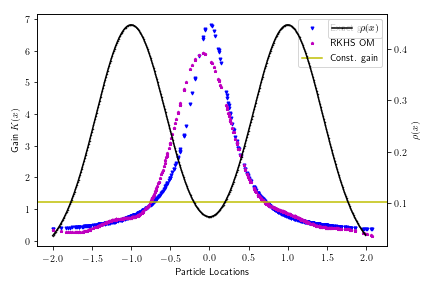

In [326]:
mse_rkhs_N,_,_ = select_hyperparameters('rkhs_N')

<IPython.core.display.Javascript object>


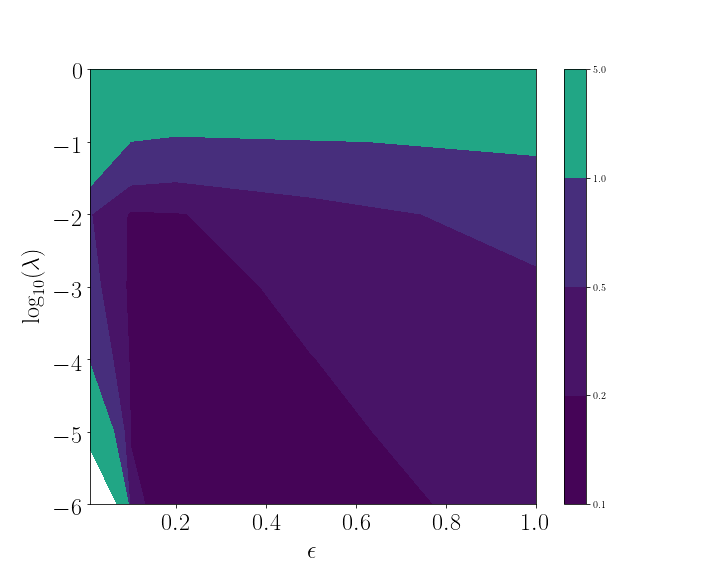

In [351]:
fig_contour_rkhs_N = contour_lambda_eps(np.mean(mse_rkhs_N,axis=0),Lambda, eps)

#### RKHS Optimal mean

Run  99
Time taken 0.9052199149737135
Time taken 5.703933716984466
Time taken 5.731598830898292
Time taken 4.959853986045346
Time taken 5.0327471839264035
Time taken 4.803436668938957
Time taken 4.835261597996578
Time taken 5.106238079955801
Time taken 5.172630270011723
Time taken 4.776465525035746
Time taken 5.149993618018925
Time taken 4.841385900042951
Time taken 4.8167140140431
Time taken 4.853118491941132
Time taken 4.8426841320469975
Time taken 5.367481466033496
Time taken 5.2247014249442145
Time taken 4.786285414011218
Time taken 4.79545983299613
Time taken 4.826304157963023
Time taken 4.779369408963248
Time taken 4.79230797290802
Time taken 4.832639241009019
Time taken 5.013919531018473
Time taken 4.9557762229815125
Time taken 4.857247675070539
Time taken 5.007218683022074
Time taken 5.012911578058265
Time taken 5.001774859032594
Time taken 5.488265219028108
Time taken 6.523851373931393
Time taken 5.009975602966733
Time taken 5.0743774130241945
Time taken 4.9361689009238034
Tim

<IPython.core.display.Javascript object>


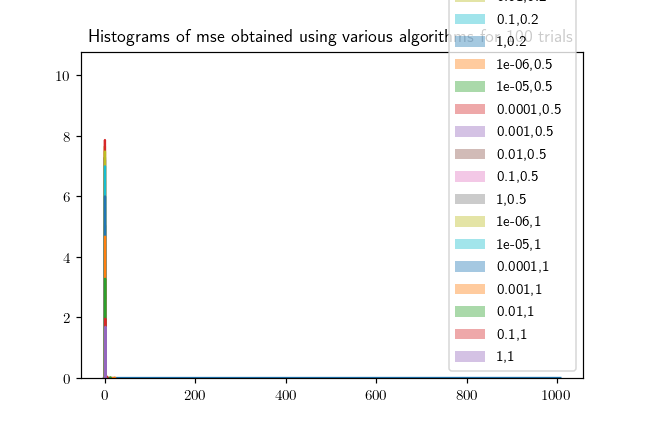

MSE for om 13.22768915049928
MSE for om 1.41909263236333


C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


MSE for om 0.928179216284081
MSE for om 0.6462388336719875
MSE for om 0.3555846448546162
MSE for om 0.6581492742993253
MSE for om 1.2956655942869244
MSE for om 0.2275780457527839
MSE for om 0.19373046095345423
MSE for om 0.16978989418998958
MSE for om 0.14452205545113123
MSE for om 0.11542040398612366
MSE for om 0.28218257547947867
MSE for om 1.0635345707950161
MSE for om 0.1464715314365118
MSE for om 0.13555963464368342
MSE for om 0.12900714229916488
MSE for om 0.1270971758724357
MSE for om 0.14067028660488
MSE for om 0.3255517539038689
MSE for om 1.0334532193686607
MSE for om 0.14924582260216604
MSE for om 0.16723837015552065
MSE for om 0.19484057580162692
MSE for om 0.2408663777860527
MSE for om 0.33575114437231834
MSE for om 0.5656053025195537
MSE for om 1.1571902106054694
MSE for om 0.24235437334118295
MSE for om 0.2876637622783109
MSE for om 0.351458380378191
MSE for om 0.4426716571071506
MSE for om 0.5779967518260062
MSE for om 0.9172857248883414
MSE for om 1.3538279543227434
Be

<IPython.core.display.Javascript object>


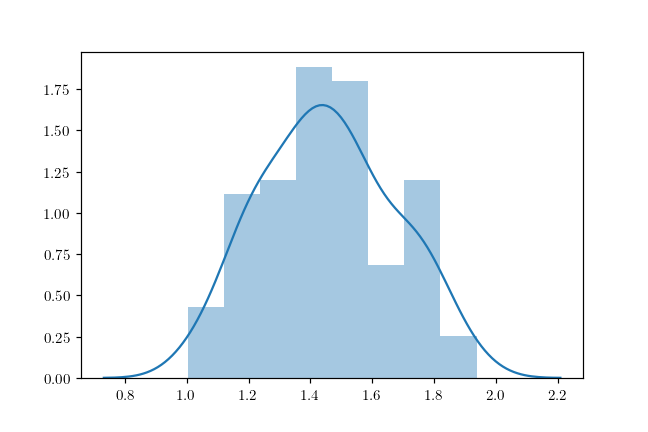

<IPython.core.display.Javascript object>


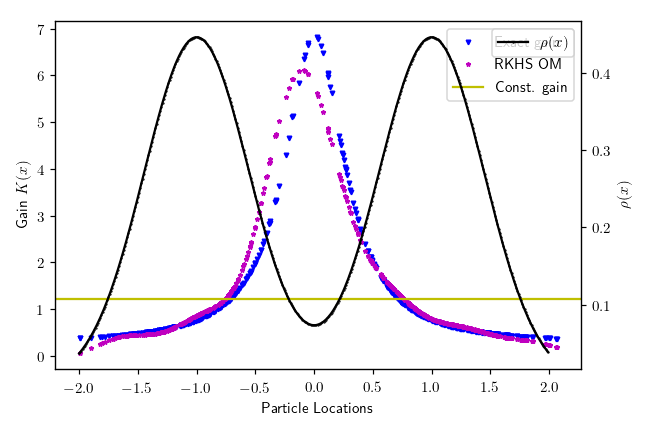

In [334]:
mse_om,_,_ = select_hyperparameters('om')

<IPython.core.display.Javascript object>


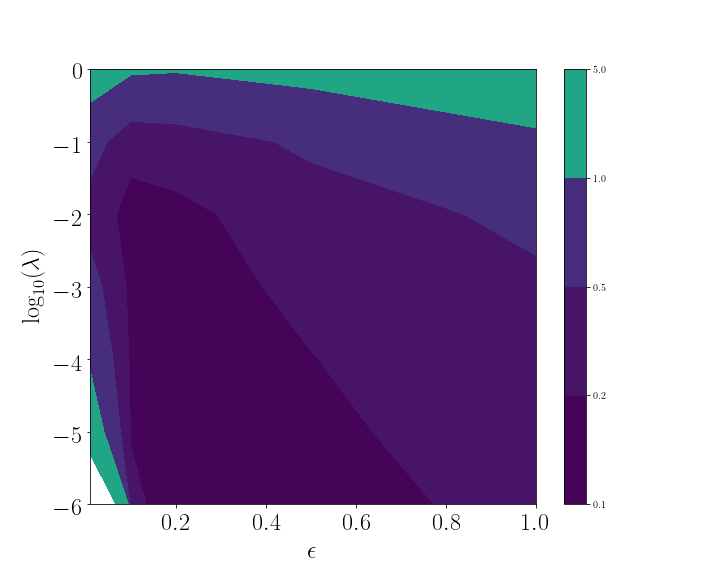

In [352]:
fig_contour_rkhs_om = contour_lambda_eps(np.mean(mse_om,axis=0),Lambda, eps)

#### Markov kernel approximation

In [ ]:
mse_coif,eps,_ = select_hyperparameters('coif')

Run  0
Time taken 0.40943515999992997


### Main function for an example with variable dimension $d$
Assume $\rho$ is an independent 2-component Gaussian mixture density along each dimension.
\begin{equation}
\rho(x) = \prod_{n=1}^d \rho_{nB}(x_n)
\end{equation}
Here, $\rho_{nB}$ is $\frac{1}{2} \mathcal{N}(-1, \sigma^2) + \frac{1}{2}\mathcal{N}(+1,\sigma^2)$ is bimodal distribution along dimension $d$. 
$c(x) = C^T x$, where $C = \mathbb{1}_d$.

Example : For $d=1$, 
\begin{equation}
\begin{aligned}
\rho(x) &= \frac{1}{2} \mathcal{N}(-1, \sigma^2) + \frac{1}{2}\mathcal{N}(+1,\sigma^2) \\
c(x) &= x \\
\text{K}(x) &=  - \frac{1}{\rho(x)} \int_{-\infty}^{x} (c(y) - \hat{c}) \rho(y) dy
\end{aligned}
\end{equation}


In [ ]:
if __name__ == '__main__':
    
    ## Flags to be set to choose which methods to compare
    exact  = 1      # Computes the exact gain and plots 
    coif   = 1     # Computes gain using Coifman kernel method
    rkhs_N = 1      # Computes gain using subspace of RKHS
    rkhs_dN= 1      # Computes optimal gain using RKHS 
    om     = 1      # Computes gain using RKHS enforcing constant gain constraint
    memory = 0      # Computes gain using RKHS with a memory parameter for previous gain
    om_mem = 0      # Computes gain using const gain approx and a memory parameter for previous gain
    
    coif_old = 0    # Computes old implementation of Coifman kernel approx. 
    const  = 1      # Computes the constant gain approximation

    # Run parameters
    No_runs = int(input('Input the number of independent trials'))
    if No_runs == None:
        No_runs = 1
    
    # FPF parameters - No. of particles
    N = int(input('Input the number of particles -'))
    if N == None:
        N = 500
    
    # System parameters
    dim = int(input('Input the dimension d -'))      # dimension of the system
    if dim == None:
        dim = 1
    x = symbols('x0:%d'%dim)
    c_coef = np.ones((1,dim))   # [1,0]
    c =  c_coef.dot(x)      # Observation function
    c_x = lambdify(x, c, 'numpy')

        
    # Parameters of the prior density \rho_B - 2 component Gaussian mixture density
    gm = dim     # No. of dimensions with Gaussian mixture densities in the dim-dimensional density, should be <= dim
    m = 2      # No of components in the Gaussian mixture
    sigma_b = [0.4472, 0.4472]   # Gives \sigma^2 = 0.2
    mu_b  = [-1, 1]
    w_b   = [0.5, 0.5]
    w_b[-1] = 1 - sum(w_b[:-1])
    p_b = 0
    for m in range(len(w_b)):
        p_b = p_b + w_b[m] * (1/ np.sqrt(2 * math.pi * sigma_b[m]**2))* exp(-(x[0] - mu_b[m])**2/ (2* sigma_b[m]**2))
    p_b_x = lambdify(x[0], p_b, 'numpy')
    
    sigma = 0.4472  # Chosen so that \sigma^2 = 0.2 as in the reference
    p = p_b
    for d in np.arange(1,dim):
        p_g = exp(-x[0]**2)/ (2 * sigma**2)
        p*= p_g
    p_g_x = lambdify(x[0], p_g, 'numpy')
    
    mse_coif = np.zeros(No_runs)
    mse_rkhs_N = np.zeros(No_runs)
    mse_rkhs_dN = np.zeros(No_runs)
    mse_om   = np.zeros(No_runs)
    mse_coif_old = np.zeros(No_runs)
    mse_const = np.zeros(No_runs)
    
    for run in range(No_runs):
        clear_output()
        print('Dimensions ', dim)
        print('Run ',run)
        seed = run
        # seed = np.random.randint(1,100)
        print('Seed ', seed)
        Xi  = get_samples(N, mu_b, sigma_b, w_b, dim, sigma, gm, seed)
        if dim == 1:
            Xi = np.sort(Xi,kind = 'mergesort')
            
        C = np.reshape(c_x(*Xi.T),(len(Xi),1))
        
        if exact == 1:   
            K_exact = np.zeros((N, dim))
            domain = np.arange(-2,2,0.01)
            K_exact_plot = np.zeros((len(domain), dim))
            for d in range(gm):
                K_exact[:,d]  = gain_num_integrate(Xi,x[0] , p_b, d)
                K_exact_plot[:,d]  = gain_num_integrate(domain.reshape((len(domain),1)),x[0] , p_b, d)

        if coif ==1:
            eps_coif = 0.1
            Phi = np.zeros(N)
            K_coif = gain_coif(Xi, C, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif[run] = mean_squared_error(K_exact, K_coif)

        if rkhs_N == 1:
            eps_rkhs_N =0.1
            Lambda_rkhs_N = 10**(-2)
            K_rkhs_N = gain_rkhs_N(Xi, C, eps_rkhs_N, Lambda_rkhs_N, diag = 0)
            if exact == 1:
                mse_rkhs_N[run] = mean_squared_error(K_exact, K_rkhs_N)

        if rkhs_dN == 1:
            eps_rkhs_dN = 0.1
            Lambda_rkhs_dN = 10**(-2)
            K_rkhs_dN = gain_rkhs_dN(Xi, C, eps_rkhs_dN, Lambda_rkhs_dN, diag = 0)
            if exact == 1:
                mse_rkhs_dN[run] = mean_squared_error(K_exact, K_rkhs_dN)

        if om == 1:
            eps_om = 0.1
            Lambda_om = 10**(-2)
            K_om = gain_rkhs_om(Xi, C, eps_om, Lambda_om, diag = 0)
            if exact == 1:
                mse_om[run] = mean_squared_error(K_exact, K_om)
                
        if coif_old == 1:
            eps_coif_old = 0.1
            Phi = np.zeros(N)
            K_coif_old = gain_coif_old(Xi, C, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif_old[run] = mean_squared_error(K_exact, K_coif_old)
        
        if const == 1:
            eta = np.mean(C)
            Y = (C -eta)
            K_const = np.mean(Y * Xi, axis = 0)
            if exact == 1:
                mse_const[run] = mean_squared_error(K_exact, K_const)     
  

### Displaying plots

#### Plotting histograms of MSEs obtained from above run

Dimensions  1
Run  0
Seed  0
Time taken 0.09976296301465482
Time taken 0.39107319293543696
Time taken 1.3048184119397774
Time taken 0.19222555693704635
Time taken 0.23353888699784875
Time taken 0.19669935398269445




<IPython.core.display.Javascript object>


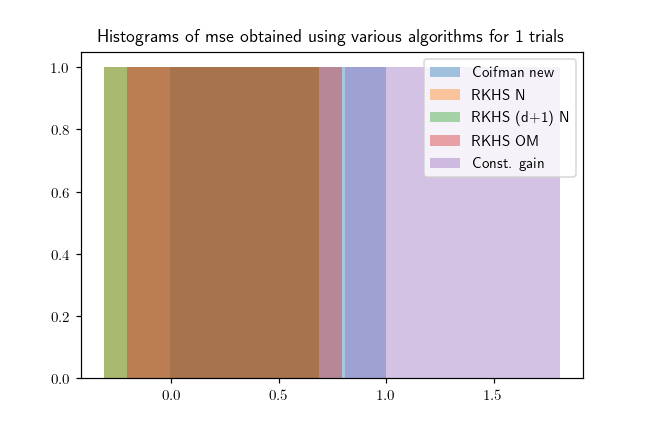

MSE for Markov kernel approx 0.4967113624033301
MSE for RKHS N 0.18693342111335276
MSE for RKHS dN 0.18693341325918064
MSE for RKHS OM 0.29365506169203115
MSE for const. gain approx. 1.3088810009515601


<IPython.core.display.Javascript object>


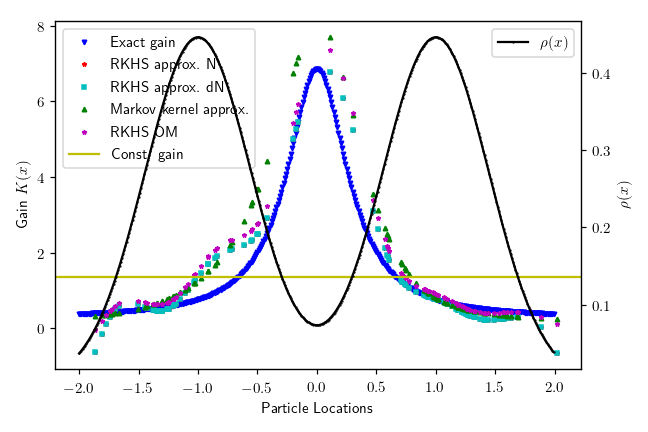

In [267]:
print('\n')
plt.figure()
if exact == 1 & coif == 1:
    print('MSE for Markov kernel approx', np.mean(mse_coif))
    sns.distplot(mse_coif,label='Coifman new')
if exact == 1 & rkhs_N == 1:
    print('MSE for RKHS N', np.mean(mse_rkhs_N))
    sns.distplot(mse_rkhs_N, label = 'RKHS N')
if exact == 1 & rkhs_dN == 1:
    print('MSE for RKHS dN', np.mean(mse_rkhs_dN))
    sns.distplot(mse_rkhs_dN, label = 'RKHS (d+1) N')
if exact == 1 & om == 1:
    print('MSE for RKHS OM', np.mean(mse_om))
    sns.distplot(mse_om, label = 'RKHS OM')
if exact == 1 & coif_old == 1:
    print('MSE for old Markov kernel', np.mean(mse_coif_old))
    sns.distplot(mse_coif_old, label = 'Coifman old')
if exact == 1 & const == 1:
    print('MSE for const. gain approx.', np.mean(mse_const))
    sns.distplot(mse_const, label = 'Const. gain')
plt.legend()
plt.title('Histograms of mse obtained using various algorithms for '+ str(No_runs) + ' trials')
plt.show()

#### Plotting the gain function approximations

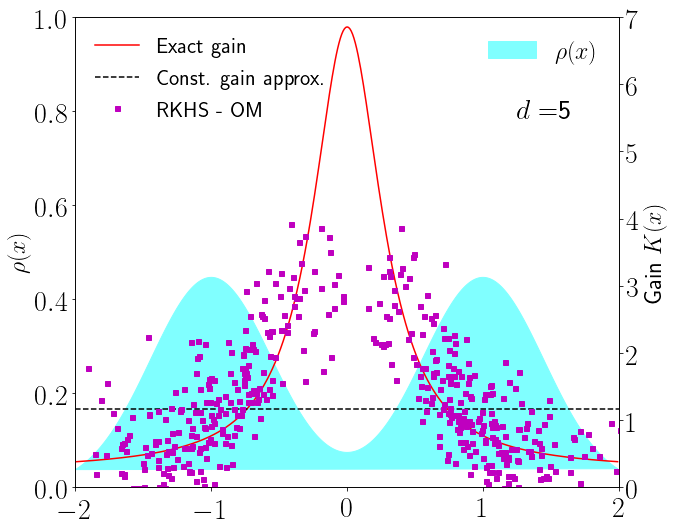

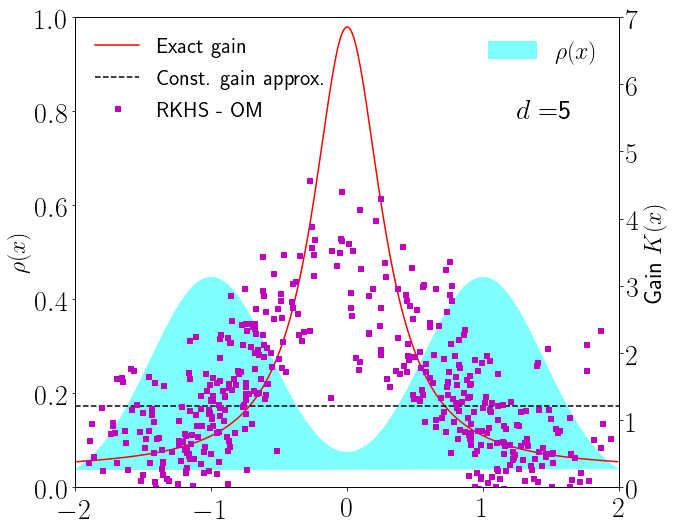

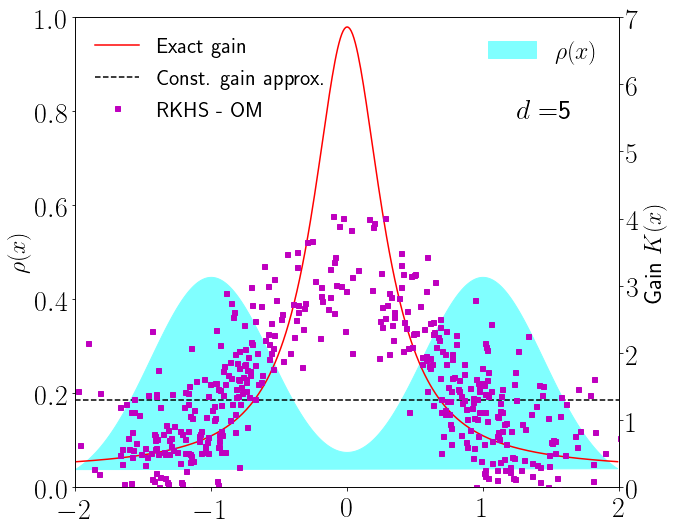

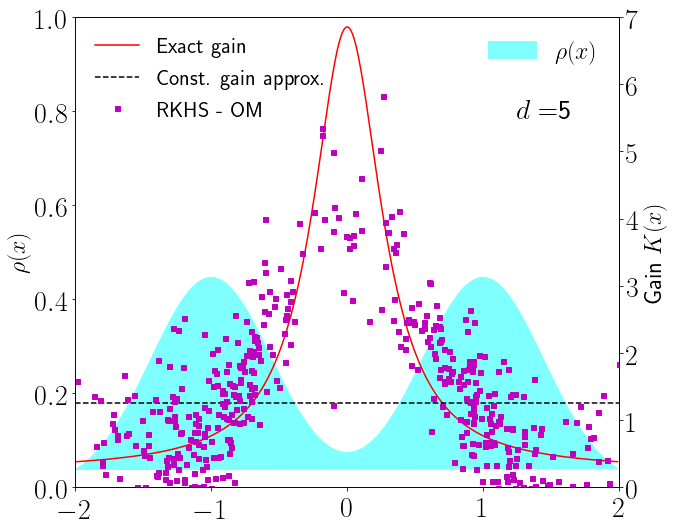

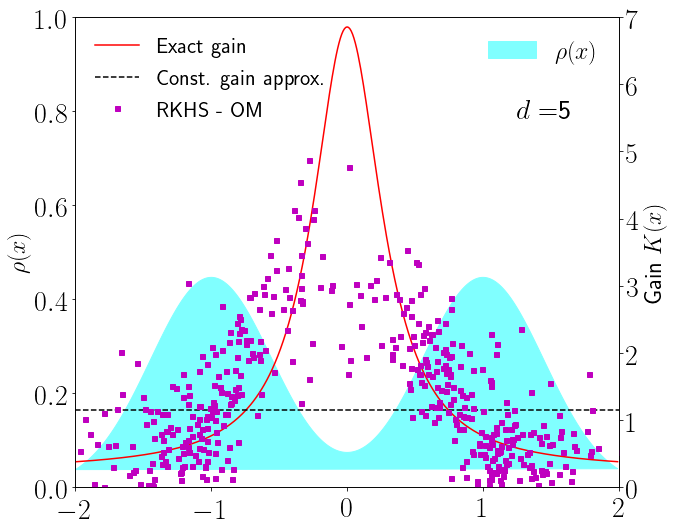

In [204]:
exact = 1
const = 1
coif = 0
rkhs_N = 0
rkhs_2N = 0
rkhs_dN = 0
om = 1
marker_size  = 5
plt.rc('text', usetex=True)
plt.rc('font', size = 28)
for d in np.arange(dim):
    fig_gain,ax1 = plt.subplots(figsize = (10,8))
    #ax1.plot(np.arange(-2,2,0.01), p_vec(np.arange(-2,2,0.01)),'k.-', markersize =1, label = r'$\rho(x)$')
    ax1.fill(np.arange(-2,2,0.01), p_b_x(np.arange(-2,2,0.01)), color = (0.5, 1, 1), label = r'$\rho(x)$')
    ax1.set_ylabel(r'$\rho(x)$', size=24)
    ax1.set_ylim((0,1))
    ax1.legend(loc=1, prop = {'size':24}, framealpha = 0)
    ax2 =ax1.twinx()
    if exact == 1:
        ax2.plot(domain, K_exact_plot[:,d], 'r-', markersize = marker_size, label ='Exact gain')
        # ax2.plot(Xi, K_num_int, 'k^', markersize = marker_size, label ='Num int. gain')
    if const == 1:
        ax2.axhline(y= K_const[d], color = 'k', linestyle = '--', label ='Const. gain approx.')
    if coif == 1:
        ax2.plot(Xi[:,d], K_coif[:,d], 'go', markersize = marker_size, label ='Markov kernel approx.')
    if rkhs_2N == 1:
        ax2.plot(Xi[:,d], K_rkhs_2N[:,d], color =(0.64,0.16,0.16), linestyle = '', marker ='v', markersize = marker_size, label = 'RKHS - Optimal')
    if rkhs_dN == 1:
        ax2.plot(Xi[:,d], K_rkhs_dN[:,d], color =(0.64,0.16,0.16), linestyle = '', marker ='v', markersize = marker_size, label = 'RKHS - Optimal')
    if rkhs_N == 1:
        ax2.plot(Xi[:,d], K_rkhs_N[:,d], 'b^', markersize = marker_size, label = 'RKHS - Simplified')
    if om == 1:
        ax2.plot(Xi[:,d], K_om[:,d], 'ms', markersize = marker_size, label = 'RKHS - OM')
    if coif_old == 1:
        ax2.plot(Xi[:,d], K_coif_old[:,d], 'y.', markersize = marker_size, label ='Old Markov kernel')
    ax2.set_xlabel('Particle Locations', size=24)
    ax2.set_ylabel('Gain $K(x)$',size=24)
    ax2.set_ylim((0,7))
    ax2.legend(loc=2, prop={'size':22}, framealpha = 0)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.xlim((-2,2))
    plt.text(1.25,5.5,'$d= $'+str(dim),fontsize = 28)
    plt.show()     

MSE for Markov kernel approx 0.1035982457617713
MSE for RKHS N 0.17001898663396742
MSE for RKHS dN 0.17001757884373864
MSE for RKHS OM 0.11542040398612366
MSE for const. gain approx. 1.4558088999943255


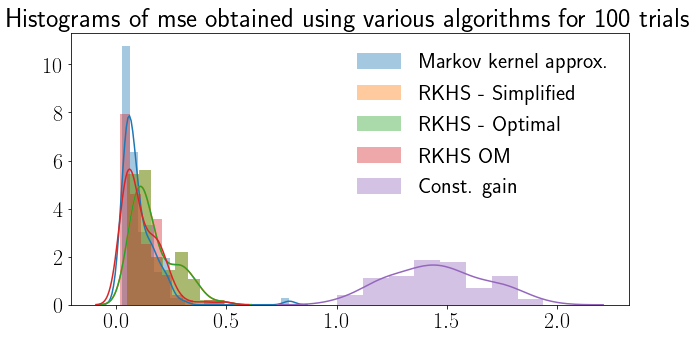

In [128]:
exact = 1
const = 1
coif = 1
rkhs_N = 1
rkhs_2N = 0
rkhs_dN = 1
om = 1
fig = plt.figure(figsize = (10,5))
if exact == 1 & coif == 1:
    print('MSE for Markov kernel approx', np.mean(mse_coif))
    sns.distplot(mse_coif,label='Markov kernel approx.')
if exact == 1 & rkhs_N == 1:
    print('MSE for RKHS N', np.mean(mse_rkhs_N))
    sns.distplot(mse_rkhs_N, label = 'RKHS - Simplified')
if exact == 1 & rkhs_2N == 1:
    print('MSE for RKHS 2N', np.mean(mse_rkhs_2N))
    sns.distplot(mse_rkhs_2N, label = 'RKHS - Optimal')
if exact == 1 & rkhs_dN == 1:
    print('MSE for RKHS dN', np.mean(mse_rkhs_dN))
    sns.distplot(mse_rkhs_dN, label = 'RKHS - Optimal')
if exact == 1 & om == 1:
    print('MSE for RKHS OM', np.mean(mse_om))
    sns.distplot(mse_om, label = 'RKHS OM')
if exact == 1 & coif_old == 1:
    print('MSE for old Markov kernel', np.mean(mse_coif_old))
    sns.distplot(mse_coif_old, label = 'Coifman old')
if exact == 1 & const == 1:
    print('MSE for const. gain approx.', np.mean(mse_const))
    sns.distplot(mse_const, label = 'Const. gain')
plt.legend(framealpha =0)
plt.title('Histograms of mse obtained using various algorithms for '+ str(No_runs) + ' trials')
plt.show()

#### Saving the figures as pdf files

In [129]:
fig.savefig('hist_mse_100.pdf')

In [205]:
fig_gain.savefig('gain_exact_const_om_d5.pdf')

In [232]:
fig_contour_rkhs_N.savefig('contour_plot_mse_N500.pdf')

### Playing with the number of particles N

In [ ]:
if __name__ == '__main__':
    
    ## Flags to be set to choose which methods to compare
    exact  = 1      # Computes the exact gain and plots 
    coif   = 1      # Computes gain using Coifman kernel method
    rkhs_N = 1      # Computes gain using subspace of RKHS
    rkhs_dN= 1      # Computes optimal gain using RKHS 
    om     = 1      # Computes gain using RKHS enforcing constant gain constraint
    memory = 0      # Computes gain using RKHS with a memory parameter for previous gain
    om_mem = 0      # Computes gain using const gain approx and a memory parameter for previous gain
    
    coif_old = 0    # Computes old implementation of Coifman kernel approx. 
    const  = 0      # Computes the constant gain approximation
    kalman = 0      # Runs Kalman Filter for comparison
    sis    = 0      # Runs Sequential Importance Sampling Particle Filter 

    # Run parameters
    No_runs = 1
    
    # FPF parameters - No. of particles
    # N_values = [10, 100, 200, 500, 1000]
    # N_values = [200]
    
    # System parameters
    dim = 5     # dimension of the system
    x = symbols('x0:%d'%dim)
    c = x[0]       # Observation function
    # c_x = lambdify(x, c, 'numpy')
    c_x = lambdify(x[0], c, 'numpy')
        
    # Parameters of the prior density \rho_B - 2 component Gaussian mixture density
    m = 2      # No of components in the Gaussian mixture
    sigma_b = [0.4472, 0.4472]   # Gives \sigma^2 = 0.2
    mu_b  = [-1, 1]
    w_b   = [0.5, 0.5]
    w_b[-1] = 1 - sum(w_b[:-1])
    p_b = 0
    for m in range(len(w_b)):
        p_b = p_b + w_b[m] * (1/ np.sqrt(2 * math.pi * sigma_b[m]**2))* exp(-(x[0] - mu_b[m])**2/ (2* sigma_b[m]**2))
    p_b_x = lambdify(x[0], p_b, 'numpy')
    sigma = 0.4472  # Chosen so that \sigma^2 = 0.2 as in the reference
    p = p_b
    for d in np.arange(1,dim):
        p_g = exp(-x[d])**2/ (2 * sigma**2)
        p*= p_g
    
    mse_coif = np.zeros((No_runs, len(N_values)))
    mse_rkhs_N = np.zeros((No_runs, len(N_values)))
    mse_rkhs_dN = np.zeros((No_runs, len(N_values)))
    mse_om   = np.zeros((No_runs, len(N_values)))
    mse_coif_old = np.zeros((No_runs, len(N_values)))
    
    for n,N in enumerate(N_values):
        print('N at ', N)
        for run in range(No_runs):   
            clear_output()
            print('Run ',run)
            Xi  = get_samples(N, mu_b, sigma_b, w_b, dim, sigma, seed = run)
            get_samples
            if dim == 1:
                Xi = np.sort(Xi,kind = 'mergesort')
            C = np.reshape(c_x(Xi[:,0]),(len(Xi),1))

            if exact == 1:

                K_exact = np.zeros((N, dim))
                K_exact[:,0]  = gain_num_integrate(Xi, c, p_b)

            if coif ==1:
                eps_coif = 0.1
                Phi = np.zeros(N)
                K_coif = gain_coif(Xi, C, eps_coif, Phi, diag = 0)
                if exact == 1:
                    mse_coif[run,n] = mean_squared_error(K_exact, K_coif)

            if rkhs_N == 1:
                eps_rkhs_N = 0.2
                Lambda_rkhs_N = 1e-2
                K_rkhs_N = gain_rkhs_N(Xi, C, eps_rkhs_N, Lambda_rkhs_N, diag = 0)
                if exact == 1:
                    mse_rkhs_N[run,n] = mean_squared_error(K_exact, K_rkhs_N)

            if rkhs_dN == 1:
                eps_rkhs_dN = 0.2
                Lambda_rkhs_dN = 1e-2
                K_rkhs_dN = gain_rkhs_dN(Xi, C, eps_rkhs_dN, Lambda_rkhs_dN, diag = 0)
                if exact == 1:
                    mse_rkhs_dN[run,n] = mean_squared_error(K_exact, K_rkhs_dN)

            if om == 1:
                eps_om = 0.2
                Lambda_om = 1e-2
                K_om = gain_rkhs_om(Xi, C, eps_om, Lambda_om, diag = 0)
                if exact == 1:
                    mse_om[run,n] = mean_squared_error(K_exact, K_om)

            if coif_old == 1:
                eps_coif_old = 0.1
                Phi = np.zeros(N)
                K_coif_old = gain_coif_old(Xi, C, eps_coif, Phi, diag = 0)
                if exact == 1:
                    mse_coif_old[run,n] = mean_squared_error(K_exact, K_coif_old)

        print('\n')
        plt.figure()
        if exact == 1 & coif == 1:
            print('MSE for Markov kernel approx', np.mean(mse_coif[:,n]))
            sns.distplot(mse_coif[:,n],label='Coifman new')
        if exact == 1 & rkhs_N == 1:
            print('MSE for RKHS N', np.mean(mse_rkhs_N[:,n]))
            sns.distplot(mse_rkhs_N[:,n], label = 'RKHS N')
        if exact == 1 & rkhs_dN == 1:
            print('MSE for RKHS dN', np.mean(mse_rkhs_dN[:,n]))
            sns.distplot(mse_rkhs_dN[:,n], label = 'RKHS (d+1) N')
        if exact == 1 & om == 1:
            print('MSE for RKHS OM', np.mean(mse_om[:,n]))
            sns.distplot(mse_om[:,n], label = 'RKHS OM')
        if exact == 1 & coif_old == 1:
            print('MSE for old Markov kernel', np.mean(mse_coif_old[:,n]))
            sns.distplot(mse_coif_old[:,n], label = 'Coifman old')
        plt.legend()
        plt.title('Histograms of mse obtained using various algorithms for '+ str(No_runs) + ' trials')
        plt.show()
    
    
        ### Displaying the plots
        marker_size  = 3
        plt.rc('text', usetex=True)
        fig,ax1 = plt.subplots()
        if exact == 1:
            ax1.plot(Xi, K_exact, 'bv', markersize = marker_size, label ='Exact gain')
        if rkhs_N == 1:
            ax1.plot(Xi, K_rkhs_N, 'r*', markersize = marker_size, label = 'RKHS approx. N')
            handles, labels = ax1.get_legend_handles_labels()
        if rkhs_dN == 1:
            ax1.plot(Xi, K_rkhs_dN, 'cs', markersize = marker_size, label = 'RKHS approx. dN')
        if coif == 1:
            ax1.plot(Xi, K_coif, 'g.', markersize = marker_size, label ='Markov kernel approx.')
        if om == 1:
            ax1.plot(Xi, K_om, 'm*', markersize = marker_size, label = 'RKHS OM')
        if coif_old == 1:
            ax1.plot(Xi, K_coif_old, 'y.', markersize = marker_size, label ='Old Markov kernel')
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend([handle for i,handle in enumerate(handles) if i%dim == 0], [label for i,label in enumerate(labels) if i%dim ==0], loc='best')
        ax2 =ax1.twinx()
        ax2.plot(np.arange(-2,2,0.01), p_b_x(np.arange(-2,2,0.01)),'k.-', markersize =1, label = r'$\rho(x)$')
        ax2.set_ylabel(r'$\rho(x)$')
        ax2.legend(loc=1)
        ax1.set_xlabel('Particle Locations')
        ax1.set_ylabel('Gain $K(x)$')
        # ax1.legend()
        plt.xticks(rotation = 45)
        plt.tight_layout()
        plt.show()     
    
        

## Setting up the problem of Gaussian mixtures in all dimensions

Poisson's equation : 
\begin{equation}
\mathcal{D}h := -\nabla U . \nabla h + \Delta h = -\tilde{c}
\end{equation}
The $d$ dimensional probability density is composed of $d$ 2-component Gaussian mixtures. 
Let $p_i$ be the density in the $i^{th}$ dimension and let $p$ be defined as 
\begin{equation}
p(x) = \prod_{i=1}^d p_i(x_i)
\end{equation}
Taking $\log$ on both sides, 
\begin{equation}
U(x) = \sum_{i=1}^d U_i(x_i)
\end{equation}
where $U = -\log(p)$.
Then,
\begin{equation}
\nabla U = \Bigl[ \frac{\partial U_1}{\partial x_1}, \frac{\partial U_2}{\partial x_2}, \cdots , \frac{\partial U_d}{\partial x_d} \Bigr]
\end{equation}
Let $h$ be the solution to Poisson's equation, then 
\begin{equation}
\begin{aligned}
\nabla h &= \Bigl[\frac{\partial h}{\partial x_1}, \frac{\partial h}{\partial x_2}, \cdots \frac{\partial h}{\partial x_d}\Bigr] \\
& = \Bigl[ K_1, K_2, \cdots, K_d\Bigr] 
\end{aligned}
\end{equation}
and, 
\begin{equation}
\Delta h = \sum_{i=1}^d \frac{\partial^2 h}{\partial x^2_i} = \sum_{i=1}^d \frac{\partial K_i}{\partial x_i}
\end{equation}
Supose, $ c(x) = c_1(x_1) + c_2(x_2) + \cdots + c_d(x_d)$  and each $c_i$ is linear in $x$,
$c(x) = [c_1 \, c_2 \, \cdots c_d] \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_d \end{bmatrix}$.

Substituting into Poisson's equation, we get
\begin{equation}
\begin{aligned}
-\Bigl[\frac{\partial U_1}{\partial x_1} \, \frac{\partial U_2}{\partial x_2} \, \cdots \frac{\partial U_d}{\partial x_d} \Bigr] \cdot \begin{bmatrix} K_1(x_1) \\ \vdots\\ K_d(x_d) + \end{bmatrix} + \sum_{i=1}^d \frac{\partial K_i(x_i)}{\partial x_i} &= -\tilde{c}(x)\\
&= -\sum_{i=1}^d \tilde{c_i}(x_i)
\end{aligned}
\end{equation}
This can be split into $d$ independent Poisson's equations as follows:
\begin{equation}
-\frac{\partial U_i}{\partial x_i} K_i(x_i) + \frac{\partial K_i(x_i)}{\partial x_i} = -\tilde{c_i}(x_i) \,\qquad\, \forall d
\end{equation}

# Rough trials

In [ ]:
mean_squared_error(K_exact[:,0], K_om[:,0])

In [ ]:
mean_squared_error(K_exact[:,2], K_om[:,2])

In [ ]:
mean_squared_error(K_exact[:,1], K_coif[:,1])

In [ ]:
f = lambda x:  x * (0.498677850501791*exp(-3.125*(x + 1)**2) + 0.498677850501791*exp(-3.125*(x - 1)**2))

In [ ]:
expf = lambda x:

In [ ]:
cp

In [ ]:
integrate.quad(expf, 0, 1)

In [ ]:
integrate.quad(f,-np.inf,np.inf)

In [ ]:
f2 = lambda x: c*p

In [ ]:
cp_vec = lambdify(x, c, 'numpy')

In [ ]:
np.mean(cp_vec(Xi))

In [ ]:
f = lambda x: cp(c,p,x)

In [ ]:
help(Symbol)

In [ ]:
N = [10, 100, 200, 500, 1000]

In [ ]:
N[4]